# Building DailyBacktester from Scratch

Will execute trades based on yfinance Close prices

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

dbs = pd.read_csv("dbs_7y.csv")
uob = pd.read_csv("uob_7y.csv")
dbs = dbs.set_index("Date")
uob = uob.set_index("Date")

In [ ]:
class DailyBacktester:
    def __init__(self, strategy, data: dict[str,pd.core.frame.DataFrame], slippage=0.001,fee=0.001):
        self.strategy = strategy # Strategy object that contains the logic for generating signals
        self.data = data #YYYY-MM-DD format
        self.slippage = slippage # Slippage percentage
        self.fee = fee # Fee percentage
        self.instruments = list(self.data.keys())
        self.dates = self.data[self.instruments[0]].index
        self.positions = {instrument: 0 for instrument in self.instruments}
        self.lots = {
            instrument: [] #{'qty': int, 'price': float}
            for instrument in self.instruments
        }
        self.cash_balance = 0
        self.realised_pnl = 0
        self.signals = None
        self.results = None
    
    def plot_results(self):
        if self.results is None:
            print("No results to display. Please run the backtest first.")
            return
        self.results['Total PNL'].plot(title='Total PNL Over Time')
        self.results['Net Cash'].plot(title='Net Cash Over Time')
        self.results['Position Value'].plot(title='Position Value Over Time')
        plt.title('Backtest Results')
        plt.xlabel('Date')
        plt.ylabel('Total PNL')
        plt.legend()
        plt.show()

        self.results['Realised PNL'].plot(title='Realised PNL Over Time')
        self.results['Exposure'].plot(title='Exposure Over Time')        
        plt.title('Backtest Results')
        plt.xlabel('Date')
        plt.ylabel('Total PNL')
        plt.legend()
        plt.show()

        self.results['Total PNL'].diff().plot(title='Rolling PNL Over Time')
        plt.title('Backtest Rolling PNL')
        plt.xlabel('Date')
        plt.ylabel('Total PNL')
        plt.show()

        #rolling Sharpe
        self.results['Rolling Sharpe'] = self.results['Total PNL'].rolling(window=30).mean() / self.results['Total PNL'].rolling(window=30).std()
        self.results['Rolling Sharpe'].plot(title='Rolling Sharpe Ratio Over Time')
        overall_sharpe = self.results['Total PNL'].mean() / self.results['Total PNL'].std()
        plt.axhline(overall_sharpe, color='red', linestyle='--', label='Overall Sharpe Ratio')
        plt.legend()
        plt.title('Sharpe Ratio')
        plt.xlabel('Date')
        plt.ylabel('Sharpe Ratio')
        plt.legend()
        plt.show()


        for instrument in self.instruments:
            self.results[f'{instrument} Position'].plot(label=f'{instrument} Position')
        plt.title('Positions Over Time')
        plt.xlabel('Date')
        plt.ylabel('Position Size')
        plt.legend()
        plt.show()

        #max drawdown
        get_peaks = self.results['Position Value'].cummax()
        peaks = list(get_peaks[get_peaks != get_peaks.shift(1)].index)
        max_drawdown = 0
        for i in range(len(peaks)-1):
            drawdown = self.results['Position Value'].loc[peaks[i]] - self.results['Position Value'][peaks[i]:peaks[i+1]].min()
            if drawdown > max_drawdown:
                max_drawdown = drawdown
        
        print(f'Max Drawdown: {max_drawdown:.2%}')
        

        

    def run(self):
        #reset positions and cash balance
        self.positions = {instrument: 0 for instrument in self.instruments}
        self.position_queue = {instrument: [] for instrument in self.instruments}
        self.lots = {
            instrument: [] #{'qty': int, 'price': float}
            for instrument in self.instruments
        }
        self.cash_balance = 0
        results = []
        signals = []
        
        ### Start Backtesting ###
        for date in self.dates:
            # Simulates receiving data for each day 
            row = {instrument: self.data[instrument].loc[date] for instrument in self.instruments}
            signal, trades = self.strategy.execute_trades(row)
            # signal and trades will be dict[str, float] and dict[str, int] respectively
            # trades for each instruent will be an integer, where 1 = buy 1, -1 = sell 1

            # Update positions based on trades
            position_value = 0
            exposure = 0
            for instrument in self.instruments:
                theo_price = row[instrument]['Close']
                 
                if instrument in trades:
                    qty = trades[instrument]
                    pos = self.positions[instrument]
                    self.positions[instrument] += qty

                    # Account for slippage and fees
                    price = theo_price
                    if qty > 0:
                        price *= (1 + self.slippage)
                    elif qty < 0:
                        price *= (1 - self.slippage)
                    self.cash_balance -= qty * price + self.fee * abs(qty) * price #fee is charged on the trade amount

                    if qty != 0 and pos * qty < 0:
                        # Closing trades
                        qty_to_close = abs(qty)
                        side = np.sign(pos)  # +1 for long, -1 for short
                        while qty_to_close > 0 and self.lots[instrument]:
                            lot = self.lots[instrument][0]
                            if abs(lot['qty']) <= qty_to_close:
                                qty_to_close -= abs(lot['qty'])
                                self.realised_pnl += lot['qty'] * (price - lot['price']) * -side
                                self.lots[instrument].pop(0)
                            else:
                                lot['qty'] -= side * qty_to_close
                                self.realised_pnl += qty_to_close * (price - lot['price']) * -side
                                qty_to_close = 0
                        if qty_to_close > 0:
                            self.lots[instrument].append({'qty': side * qty_to_close, 'price': price})
                    else:
                        self.lots[instrument].append({'qty': qty, 'price': price})
                         
                
                position_value += self.positions[instrument] * theo_price
                exposure += abs(self.positions[instrument] * theo_price)
            
            res = {
                'Date': date,
                'Net Cash': self.cash_balance,
                'Position Value': position_value,
                'Total PNL': position_value + self.cash_balance,
                'Realised PNL': self.realised_pnl,
                'Exposure': exposure,
            }
            for instrument in self.instruments:
                    res[f'{instrument} Position'] = self.positions[instrument]
            
            results.append(res)
            signal['Date'] = date
            signals.append(signal)

        
        # Convert results to DataFrame

        df = pd.DataFrame(results)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        self.results = df
        df = pd.DataFrame(signals)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        self.signals = df
        return self.results.loc[self.dates[-1]]['Total PNL'] #return the last date's total PNL


-773.7286410226557


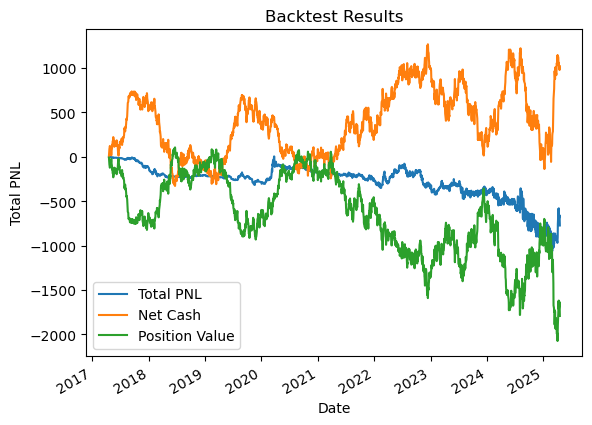

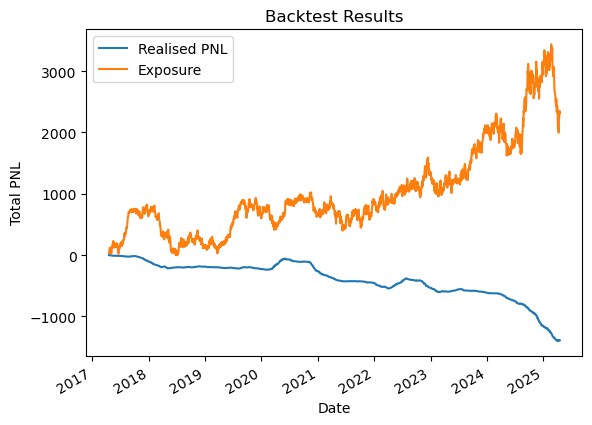

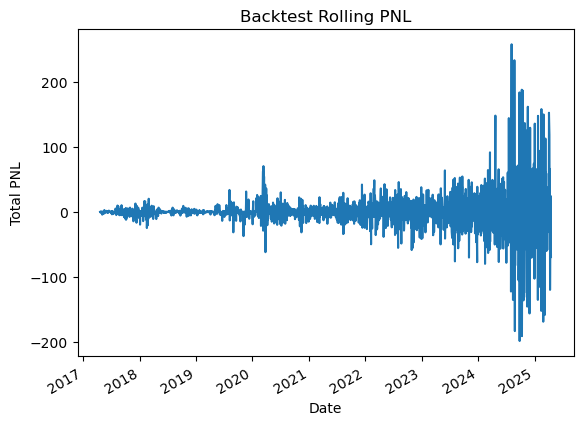

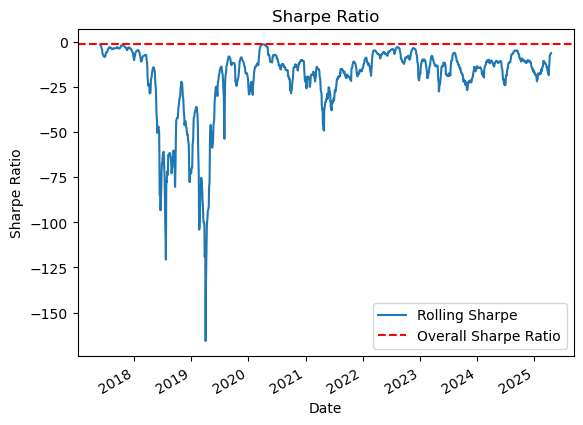

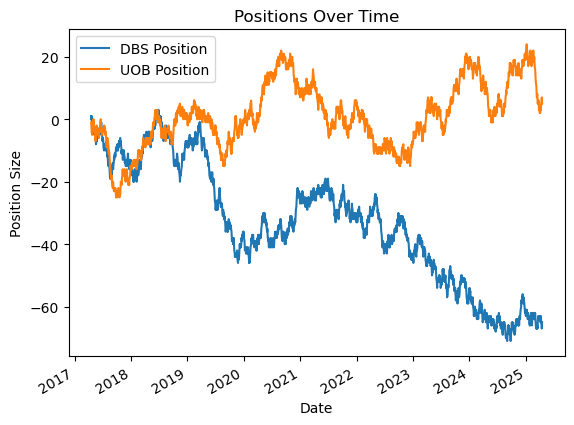

Max Drawdown: 81241.58%
            buy DBS  buy UOB
Date                        
2017-04-18        1       -1
2017-04-19       -1       -1
2017-04-20        1       -1
2017-04-21       -1       -1
2017-04-24       -1       -1
...             ...      ...
2025-04-11       -1        1
2025-04-14       -1        1
2025-04-15       -1        1
2025-04-16        1       -1
2025-04-17        1       -1

[2013 rows x 2 columns]


In [96]:
class testStrat:
    def __init__(self, window=20):
        self.data = {}
        self.instruments = []

    def execute_trades(self, row):
        signals = {}
        trades = {}
        for instrument in row.keys():
            if instrument not in self.instruments:
                self.instruments.append(instrument)
                self.data[instrument] = []
            self.data[instrument].append(row[instrument])
            if len(self.data[instrument]) > 20:
                self.data[instrument].pop(0)
            signals[f'buy {instrument}'] = 1 if np.random.rand() > 0.5 else -1
            trades[instrument] = int(signals[f'buy {instrument}'])
        return signals, trades



# class testStrat:
#     def __init__(self, window=20):
#         self.data = {}
#         self.instruments = []
#         self.n = 1

#     def execute_trades(self, row):
#         signals = {}
#         trades = {}
#         trades['DBS'] = self.n#*(-1)**self.n
#         self.n = (self.n + 1) % 4
#         return signals, trades
    
backtester = DailyBacktester(testStrat(), {'DBS': dbs, 'UOB': uob})
results = backtester.run()
print(results)
backtester.plot_results()
signals = backtester.signals
print(signals)